In [1]:
# load category id to name mapping from ImageNet-Mini/imagenet_class_index.json
import json
with open('./ImageNet-Mini/imagenet_class_index.json') as f:
    class_idx = json.load(f)
id2label = {x[0]: (x[1], int(n)) for n, x in class_idx.items()}
idx2label = {int(n): x[1] for n, x in class_idx.items()}

In [2]:
# Find paths to all images in the imagenet-mini / images folder
def get_image_paths(image_folder):
    import os
    image_paths = []
    for root, dirs, files in os.walk(image_folder):
        for file in files:
            if file.endswith(".JPEG"):
                image_paths.append(os.path.join(root, file))
    return image_paths

image_paths = get_image_paths("./ImageNet-Mini/images")
image_paths[:3]

['./ImageNet-Mini/images/n02123394/ILSVRC2012_val_00003382.JPEG',
 './ImageNet-Mini/images/n02123394/ILSVRC2012_val_00002036.JPEG',
 './ImageNet-Mini/images/n02123394/ILSVRC2012_val_00010218.JPEG']

In [3]:
import argparse
import sys
import torch
from PIL import Image
from torchvision import transforms
import numpy as np
import cv2
from vit_explain.vit_rollout import VITAttentionRollout
from vit_explain.vit_grad_rollout import VITAttentionGradRollout#, grad_rollout
import matplotlib.pyplot as plt

def grad_rollout_contrastive(attentions, gradients, discard_ratio):
    result = torch.eye(attentions[0].size(-1))
    with torch.no_grad():
        for attention, grad in zip(attentions, gradients):                
            weights = grad
            attention_heads_fused = (attention*weights).mean(axis=1)
            # attention_heads_fused[attention_heads_fused < 0] = 0

            # Drop the lowest attentions, but
            # don't drop the class token
            flat = attention_heads_fused.view(attention_heads_fused.size(0), -1)
            _, indices = flat.topk(int(flat.size(-1)*discard_ratio), -1, False)
            #indices = indices[indices != 0]
            flat[0, indices] = 0

            I = torch.eye(attention_heads_fused.size(-1))
            a = (attention_heads_fused + 1.0*I)/2
            a = a / a.sum(dim=-1)
            result = torch.matmul(a, result)
    
    # Look at the total attention between the class token,
    # and the image patches
    mask = result[0, 0 , 1 :]
    # In case of 224x224 image, this brings us from 196 to 14
    width = int(mask.size(-1)**0.5)
    mask = mask.reshape(width, width).numpy()
    mask = mask / np.max(mask)
    return mask  

class VITAttentionGradRollout_Contrastive:
    def __init__(self, model, attention_layer_name='attn_drop',
        discard_ratio=0.9):
        self.model = model
        self.discard_ratio = discard_ratio
        for name, module in self.model.named_modules():
            if attention_layer_name in name:
                module.register_forward_hook(self.get_attention)
                module.register_backward_hook(self.get_attention_gradient)

        self.attentions = []
        self.attention_gradients = []

    def get_attention(self, module, input, output):
        self.attentions.append(output.cpu())

    def get_attention_gradient(self, module, grad_input, grad_output):
        self.attention_gradients.append(grad_input[0].cpu())

    def __call__(self, input_tensor, category_index):
        self.model.zero_grad()
        output = self.model(input_tensor)
        output = torch.softmax(output, dim=-1)
        category_mask = torch.zeros(output.size())
        category_mask[:, category_index] = 1
        loss = (output*category_mask).sum()
        loss.backward()

        return grad_rollout_contrastive(self.attentions, self.attention_gradients,
            self.discard_ratio)

class VITAttentionGradRollout_Contrastive_wo_softmax:
    def __init__(self, model, attention_layer_name='attn_drop',
        discard_ratio=0.9):
        self.model = model
        self.discard_ratio = discard_ratio
        for name, module in self.model.named_modules():
            if attention_layer_name in name:
                module.register_forward_hook(self.get_attention)
                module.register_backward_hook(self.get_attention_gradient)

        self.attentions = []
        self.attention_gradients = []

    def get_attention(self, module, input, output):
        self.attentions.append(output.cpu())

    def get_attention_gradient(self, module, grad_input, grad_output):
        self.attention_gradients.append(grad_input[0].cpu())

    def __call__(self, input_tensor, category_index):
        self.model.zero_grad()
        output = self.model(input_tensor)
        # output = torch.softmax(output, dim=-1)
        category_mask = torch.zeros(output.size())
        category_mask[:, category_index] = 1
        loss = (output*category_mask).sum()
        loss.backward()

        return grad_rollout_contrastive(self.attentions, self.attention_gradients,
            self.discard_ratio)

def show_mask_on_image(img, mask):
    img = np.float32(img) / 255
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

import matplotlib.colors as mcolors
def show_mask_on_image_contrastive(img, mask):
    # Normalize mask to be in the range [-1, 1]
    norm = mcolors.TwoSlopeNorm(vcenter=0, vmin=np.min(mask), vmax=np.max(mask))

    # Apply the normalization to mask
    normalized_mask = norm(mask)

    # Create a colormap (blue for negative, red for positive)
    cmap = plt.get_cmap('bwr')

    # Apply colormap
    heatmap = cmap(normalized_mask)

    # Convert heatmap to BGR format for OpenCV
    heatmap = np.uint8(255 * heatmap)[..., :3]
    heatmap_rgb = heatmap[..., ::3]

    # Superimpose the heatmap on image
    cam = heatmap_rgb * 0.5 + img * 0.5
    return np.uint8(255 * cam)

def process_image(use_cuda=False, image_path='./examples/both.png',
                  discard_ratio=0.9, category_index=None, saveind=False):
    model = torch.hub.load('facebookresearch/deit:main', 
        'deit_tiny_patch16_224', pretrained=True)
    model.eval()

    if use_cuda:
        model = model.cuda()

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])
    img = Image.open(image_path)
    img = img.resize((224, 224))
    input_tensor = transform(img).unsqueeze(0)
    if use_cuda:
        input_tensor = input_tensor.cuda()

    if category_index is None:
        raise ValueError("category_index must be specified")
    else:
        print("Doing Gradient Attention Rollout")
        grad_rollout = VITAttentionGradRollout(model, discard_ratio=discard_ratio)
        mask = grad_rollout(input_tensor, category_index)
        grad_rollout_contrastive = VITAttentionGradRollout_Contrastive(model, 
            discard_ratio=discard_ratio)
        mask_contrastive = grad_rollout_contrastive(input_tensor, category_index)

        grad_rollout_contrastive_wo_softmax = VITAttentionGradRollout_Contrastive_wo_softmax(model, 
            discard_ratio=discard_ratio)
        mask_contrastive_wo_softmax = grad_rollout_contrastive_wo_softmax(input_tensor, category_index)

    np_img = np.array(img)[:, :, ::-1]  # Convert from PIL to OpenCV format
    mask = cv2.resize(mask, (np_img.shape[1], np_img.shape[0]))
    mask_contrastive = cv2.resize(mask_contrastive, (np_img.shape[1], np_img.shape[0]))
    mask_contrastive_wo_softmax = cv2.resize(mask_contrastive_wo_softmax, (np_img.shape[1], np_img.shape[0]))

    # diff the two masks
    mask_diff = np.abs(mask_contrastive_wo_softmax - mask_contrastive)
    mask_diff = mask_diff / np.max(mask_diff)

    mask = show_mask_on_image(np_img, mask)
    mask_contrastive = show_mask_on_image(np_img, mask_contrastive)
    mask_diff = show_mask_on_image(np_img, mask_diff)
    mask_contrastive_wo_softmax = show_mask_on_image(np_img, mask_contrastive_wo_softmax)

    # Convert from BGR to RGB for matplotlib
    np_img_rgb = cv2.cvtColor(np_img, cv2.COLOR_BGR2RGB)
    mask_rgb = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    mask_contrastive_rgb = cv2.cvtColor(mask_contrastive, cv2.COLOR_BGR2RGB)
    mask_diff = cv2.cvtColor(mask_diff, cv2.COLOR_BGR2RGB)
    mask_contrastive_wo_softmax = cv2.cvtColor(mask_contrastive_wo_softmax, cv2.COLOR_BGR2RGB)

    # Display images using matplotlib
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 5, 1)
    plt.imshow(np_img_rgb)
    category_id = image_path.split("/")[-2]
    plt.title(f"Input Image: {id2label[category_id][0]}")
    plt.axis('off')

    plt.subplot(1, 5, 2)
    plt.imshow(mask_rgb)
    plt.title(f"Attention Rollout: {idx2label[category_index]}")
    plt.axis('off')

    plt.subplot(1, 5, 3)
    plt.imshow(mask_contrastive_wo_softmax)
    plt.title(f"Contrastive w/o softmax: { idx2label[category_index]}")
    plt.axis('off')

    plt.subplot(1, 5, 4)
    plt.imshow(mask_contrastive_rgb)
    plt.title(f"Contrastive: { idx2label[category_index]}")
    plt.axis('off')
    
    plt.subplot(1, 5, 5)
    plt.imshow(mask_diff)
    plt.title("Difference: Standard - Contrastive")
    plt.axis('off')

    plt.show()

    if saveind:
        # save individual images
        plt.imsave(f'./results/original.png', np_img_rgb)
        plt.imsave(f'./results/standard.png', mask_rgb)
        plt.imsave(f'./results/standard_contrastive.png', mask_contrastive_wo_softmax)
        plt.imsave(f'./results/contrastive.png', mask_contrastive_rgb)
        plt.imsave(f'./results/difference.png', mask_diff)

Image Category: digital_watch


Using cache found in /home/ant/.cache/torch/hub/facebookresearch_deit_main


Doing Gradient Attention Rollout


/home/ant/miniconda3/envs/dl/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


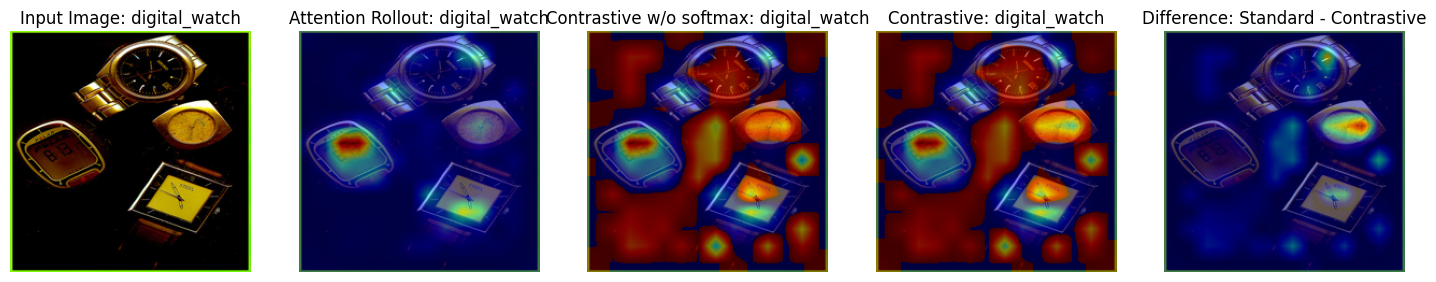

Image Category: stopwatch
Doing Gradient Attention Rollout


Using cache found in /home/ant/.cache/torch/hub/facebookresearch_deit_main


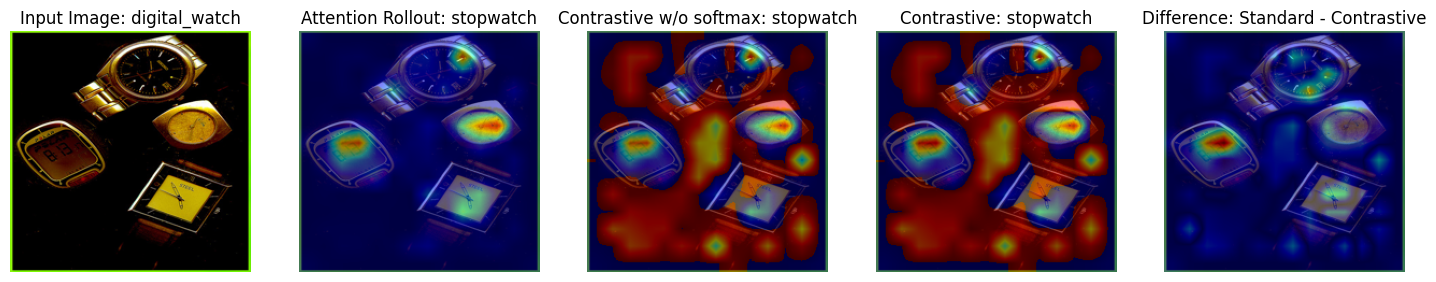

Image Category: cardoon
Doing Gradient Attention Rollout


Using cache found in /home/ant/.cache/torch/hub/facebookresearch_deit_main


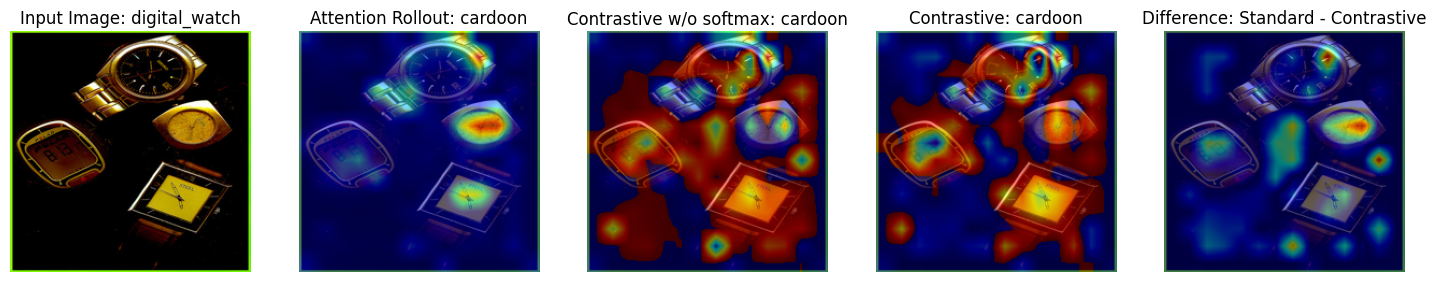

In [4]:
image_path = "ImageNet-Mini/images/n04008634/ILSVRC2012_val_00010103.JPEG" # Missile/Projectile
image_path = "ImageNet-Mini/images/n07614500/ILSVRC2012_val_00034189.JPEG" # Chocolate Sauce/Ice Cream
image_path = "ImageNet-Mini/images/n03197337/ILSVRC2012_val_00003455.JPEG" # Stopwatch/Digital Watch

image_category_id = image_path.split("/")[-2]
image_category, image_category_idx = id2label[image_category_id]
print("Image Category:", image_category)
process_image(image_path=image_path, discard_ratio=0, category_index=image_category_idx)
image_category_id = "n03773504" # Missile ID
image_category_id = "n07836838" # Chocolate Sauce ID
image_category_id = "n04328186" # Stopwatch ID
image_category, image_category_idx = id2label[image_category_id]
print("Image Category:", image_category)
process_image(image_path=image_path, discard_ratio=0, category_index=image_category_idx)
image_category, image_category_idx = id2label[image_category_id]
# Randomly sample an image category
import random
image_category_id = random.choice(list(id2label.keys()))
image_category, image_category_idx = id2label[image_category_id]
print("Image Category:", image_category)
process_image(image_path=image_path, discard_ratio=0, category_index=image_category_idx)